### F1 스코어


- F1스코어는 정밀도와 재현율을 결합한 지표


- 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐


- 사이킷런은 f1_score() API 제공


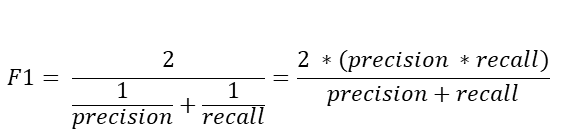

In [3]:
import pandas as pd

titanic_df = pd.read_csv('./titanic_train.csv')

from sklearn.preprocessing import LabelEncoder

def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df
    
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression(solver = 'liblinear')

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

In [4]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print('F1스코어: {0:.4f}'.format(f1))

F1스코어: 0.7966


In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    #f1스코어 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

from sklearn.preprocessing import Binarizer    

thresholds = [0.4, 0.45, 0.5, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F1:0.7576
임계값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1:0.7869
임계값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F1:0.7966
임계값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F1:0.7965
임계값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1:0.8000


- f1스코어는 임곗값이 0.6일 때 가장 좋은 값을 보여줌, 그러나 재현율이 크게 감소하고 있음

### ROC곡선과 AUC


- ROC곡선과 이에 기반한 AUC스코어는 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표


- ROC곡선은 FPR(False Positive Rate, X축)이 변할 때, TPR(True Positive Rate, 재현율, Y축)이 어떻게 변하는가를 곡선 형태로 나타냄


- 특이도(TNR, True Negative Rate): 재현율(민감도)에 대응하는 지표, 실제값 negative가 정확히 예측되어야 하는 수준을 나타냄 ex) 질병이 없는 건강한 사람은 질병이 없는 음성으로 판정

     ㄴ TNR = TN / (FP + TN)


- FPR = FP / (FP + TN) 1 - TNR

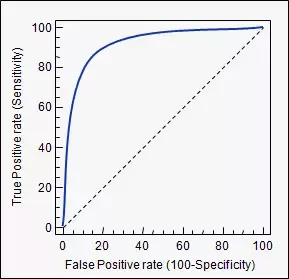


- ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지고, 멀어질수록 성능이 뛰어난 것


- ROC곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화값을 구함 >> 앞서 배운 분류 결정 임계값을 변경하면 됌!


→ 분류 결정 임계값은 'Positive 예측값을 결정하는 확률의 기준'이므로 FPR을 0으로 만들려면 임계값을 1로 지정하면 된다

→ 임계값이 1이 되면 positive 예측 기준이 매우 높기 때문에 Classifier가 임계값보다 높은 확률을 가진 데이터를 positive로 예측할 수 없기 때문


> FPR = FP / (FP + TN)


→ 반대로 FPR을 1로 만드려면 TN을 0으로 만들면 됌

→ 분류 결정 임계값을 0으로 지정하면 Classifier의 Positive 확률 기준이 너무 낮아서 다 Positive로 예측함, 그럼 Negative 예측이 아예 없기 때문에 TN이 0이 되고 FP / FP가 되어 FPR이 1이 됨

In [13]:
import numpy as np
from sklearn.metrics import roc_curve

#레이블 값이 1일 때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

#반환된 임계값 배열에서 샘플로 데이터를 추출하되 임계값을 5 step으로 추출
#thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index:', thr_index)
print('샘플 index로 추출한 임계값:', np.round(thresholds[thr_index], 2))
      
#5 step 단위로 추출된 임계값에 따른 FPR, TPR값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임계값: [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임계값별 FPR:  [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임계값별 TPR:  [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


- 임계값이 1에 가까운 값에서 작아질수록 FPR이 조금씩 커지고 TPR은 가파르게 커진다


- 이를 시각화해보자

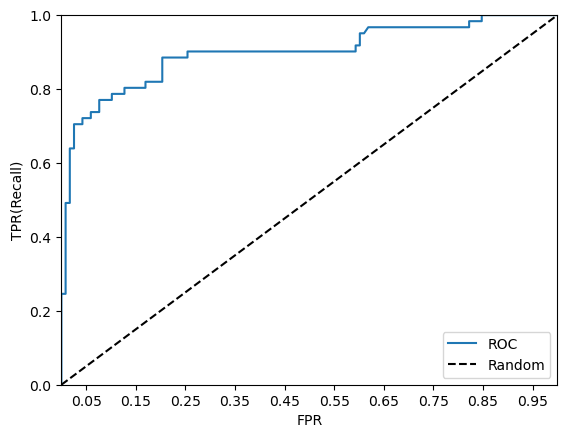

In [14]:
import matplotlib.pyplot as plt

def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label='ROC')   #ROC곡선 그리기
    plt.plot([0, 1], [0, 1], 'k--', label='Random')  #가운데 직선 그리기
    
    #FPR x축의 scale을 0.1단위로 변경, 축 이름 설정
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

- 일반적으로 ROC곡선 자체는 FPR과 TPR의 변화값을 보는데 이용


- 분류의 성능 지표로 사용되는 것은 ROC곡선 밑의 면적인 AUC값 >> 1에 가까울수록 좋은 수치 >> 수치가 올라가려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건임


- 가운데 직선에서 멀어지고 왼쪽 상단 모서리쪽으로 가파르게 곡선이 이동할수록 직사각형에 가까워져서 면적이 1에 가까워짐

In [15]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8987
